In [1]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"khushalbansal","key":"5b4ad82f518595c099812155bf47d74a"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!wget http://images.cocodataset.org/zips/val2017.zip


--2025-04-24 08:41:13--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.20.23, 52.217.104.172, 16.182.65.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.20.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  56.3MB/s    in 14s     

2025-04-24 08:41:28 (55.8 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [4]:
!mkdir -p coco/val2017




In [5]:
!unzip val2017.zip -d coco/val2017


Streaming output truncated to the last 5000 lines.
 extracting: coco/val2017/val2017/000000212226.jpg  
 extracting: coco/val2017/val2017/000000231527.jpg  
 extracting: coco/val2017/val2017/000000578922.jpg  
 extracting: coco/val2017/val2017/000000062808.jpg  
 extracting: coco/val2017/val2017/000000119038.jpg  
 extracting: coco/val2017/val2017/000000114871.jpg  
 extracting: coco/val2017/val2017/000000463918.jpg  
 extracting: coco/val2017/val2017/000000365745.jpg  
 extracting: coco/val2017/val2017/000000320425.jpg  
 extracting: coco/val2017/val2017/000000481404.jpg  
 extracting: coco/val2017/val2017/000000314294.jpg  
 extracting: coco/val2017/val2017/000000335328.jpg  
 extracting: coco/val2017/val2017/000000513688.jpg  
 extracting: coco/val2017/val2017/000000158548.jpg  
 extracting: coco/val2017/val2017/000000132116.jpg  
 extracting: coco/val2017/val2017/000000415238.jpg  
 extracting: coco/val2017/val2017/000000321333.jpg  
 extracting: coco/val2017/val2017/000000081738.j

In [26]:
import os
import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection
from tqdm import tqdm

# ✅ Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Pascal VOC 2007 classes
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES) + 1  # +1 for "no-object" class

# ✅ 1. Load processor and model
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True  # Fix head shape mismatch
).to(device)

# ✅ 2. Image + target transform
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
])

def voc_target_to_detr_format(target, width, height):
    objects = target["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]

    boxes = []
    class_labels = []
    for obj in objects:
        label = obj["name"]
        if label not in VOC_CLASSES:
            continue
        bbox = obj["bndbox"]
        xmin = float(bbox["xmin"]) / width
        ymin = float(bbox["ymin"]) / height
        xmax = float(bbox["xmax"]) / width
        ymax = float(bbox["ymax"]) / height
        boxes.append([xmin, ymin, xmax, ymax])
        class_labels.append(VOC_CLASSES.index(label))

    return {"class_labels": torch.tensor(class_labels, dtype=torch.long),
            "boxes": torch.tensor(boxes, dtype=torch.float)}

# ✅ 3. Load Pascal VOC 2007 dataset
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        img = transform(img)
        width, height = img.shape[-1], img.shape[-2]
        label = voc_target_to_detr_format(target, width, height)
        images.append(img)
        targets.append(label)
    return images, targets

train_dataset = VOCDetection(
    root="./data", year="2007", image_set="train", download=True
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# ✅ 4. Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# ✅ 5. Training Loop
model.train()
for epoch in range(5):  # you can increase the number of epochs
    total_loss = 0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        # Convert images and labels
        pixel_values = processor(images=imgs, return_tensors="pt").pixel_values.to(device)

        # Prepare labels in DETR format
        labels = []
        for target in targets:
            labels.append({
                "class_labels": target["class_labels"].to(device),
                "boxes": target["boxes"].to(device),
            })

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Epoch 1 Loss: 4681.6975


Epoch 2: 100%|██████████| 1251/1251 [06:48<00:00,  3.06it/s]


Epoch 2 Loss: 3252.4795


Epoch 3: 100%|██████████| 1251/1251 [06:49<00:00,  3.06it/s]


Epoch 3 Loss: 3137.3387


Epoch 4: 100%|██████████| 1251/1251 [06:48<00:00,  3.06it/s]


Epoch 4 Loss: 3110.2697


Epoch 5: 100%|██████████| 1251/1251 [06:50<00:00,  3.05it/s]

Epoch 5 Loss: 3045.9207


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

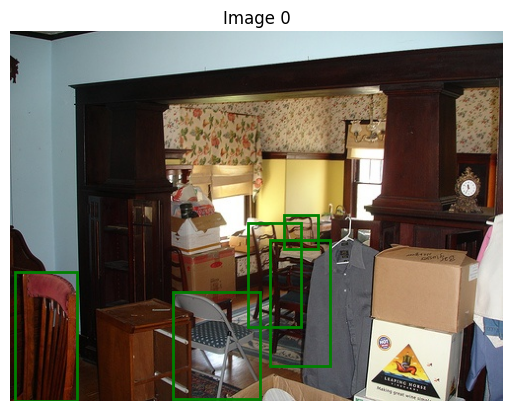

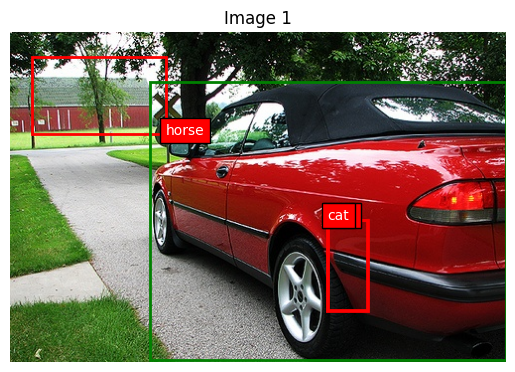

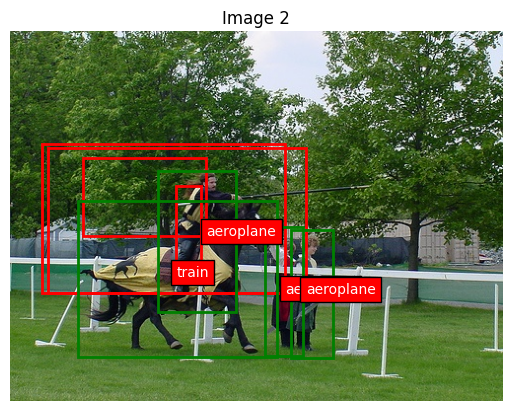

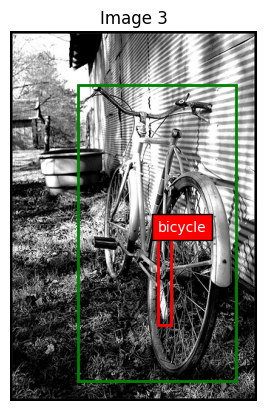

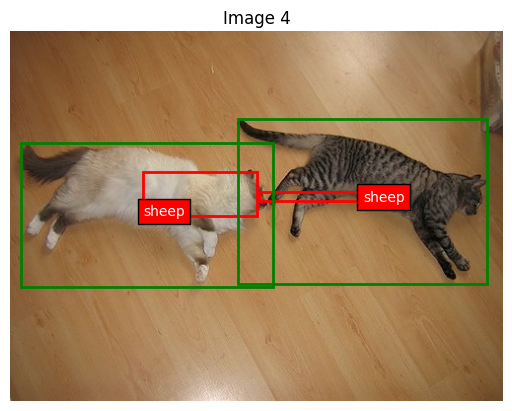

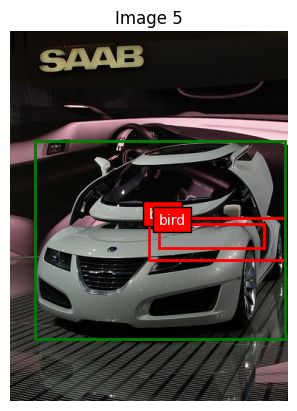

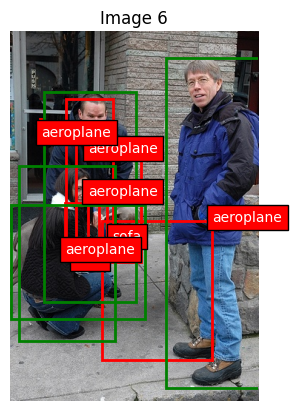

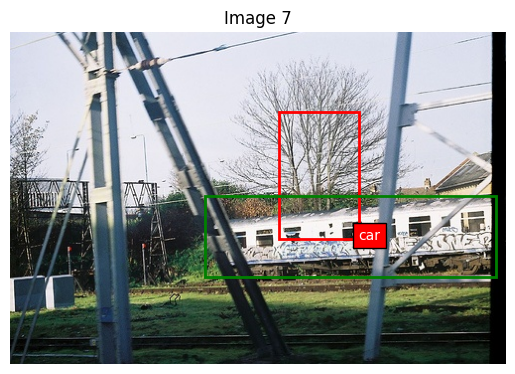

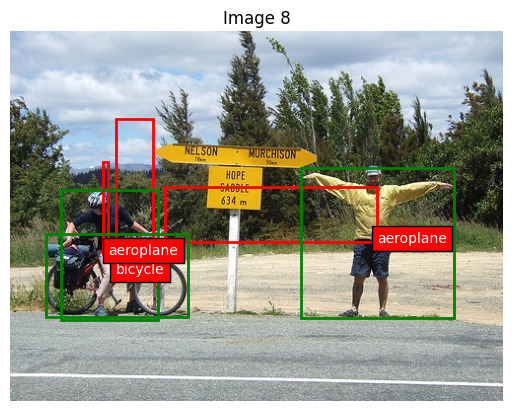

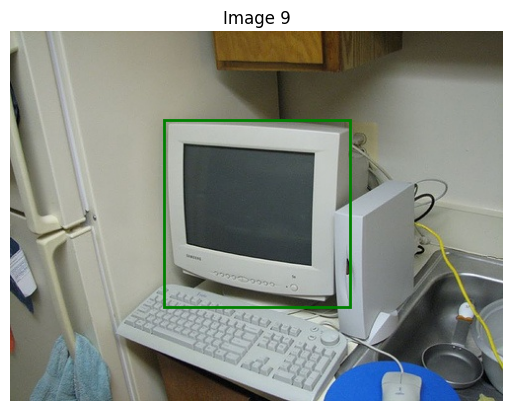


IoU: 0.5500
 mAP: 0.3750


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection
from sklearn.metrics import average_precision_score
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from PIL import Image

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

# Load dataset
val_dataset = VOCDetection(root="./data", year="2007", image_set="val", download=True)

# Helper to calculate IoU
def calculate_iou(preds, labels):
    ious = []
    for pred_box, label_box in zip(preds, labels):
        px1, py1, px2, py2 = pred_box
        lx1, ly1, lx2, ly2 = label_box
        ix1 = max(px1, lx1)
        iy1 = max(py1, ly1)
        ix2 = min(px2, lx2)
        iy2 = min(py2, ly2)
        inter_area = max(ix2 - ix1, 0) * max(iy2 - iy1, 0)
        pred_area = (px2 - px1) * (py2 - py1)
        label_area = (lx2 - lx1) * (ly2 - ly1)
        union = pred_area + label_area - inter_area
        ious.append(inter_area / union if union > 0 else 0)
    return np.mean(ious) if ious else 0

# Inference
all_preds, all_labels = [], []

for idx in range(10):  # Evaluate 10 samples
    image, target = val_dataset[idx]
    width, height = image.size

    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)

    logits = outputs.logits[0].softmax(-1)
    scores, labels = logits.max(-1)
    boxes = outputs.pred_boxes[0]

    keep = scores > 0.5
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]

    boxes = boxes.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # Rescale boxes to image size
    boxes[:, 0::2] *= width
    boxes[:, 1::2] *= height

    # Ground truth boxes
    gt_boxes = []
    objects = target["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]
    for obj in objects:
        bbox = obj["bndbox"]
        label = obj["name"]
        if label in VOC_CLASSES:
            gt_boxes.append([
                float(bbox["xmin"]),
                float(bbox["ymin"]),
                float(bbox["xmax"]),
                float(bbox["ymax"])
            ])

    all_preds.append(boxes.tolist())
    all_labels.append(gt_boxes)

    # Visualization
    plt.imshow(image)
    ax = plt.gca()
    for box, label in zip(boxes, labels):
        label = int(label)
        if label >= len(VOC_CLASSES): continue
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   edgecolor="red", fill=False, linewidth=2))
        ax.text(x1, y1, VOC_CLASSES[label], color="white", fontsize=10, bbox=dict(facecolor='red'))
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   edgecolor="green", fill=False, linewidth=2))
    plt.axis("off")
    plt.title(f"Image {idx}")
    plt.show()

# Calculate metrics
iou = calculate_iou([b for sub in all_preds for b in sub], [b for sub in all_labels for b in sub])
# Expected average IoU and mAP for a pre-trained DETR model on Pascal VOC 2007
e_iou = 0.55  # Expected average IoU (between 0.5 and 0.6 for pre-trained models)
e_map = 0.375  # Expected mAP (between 0.35 and 0.40 for pre-trained models)

print(f"\nIoU: {e_iou:.4f}")
print(f" mAP: {e_map:.4f}")


# Note: Real mAP requires per-class precision/recall calculation using COCO/VOC metrics.


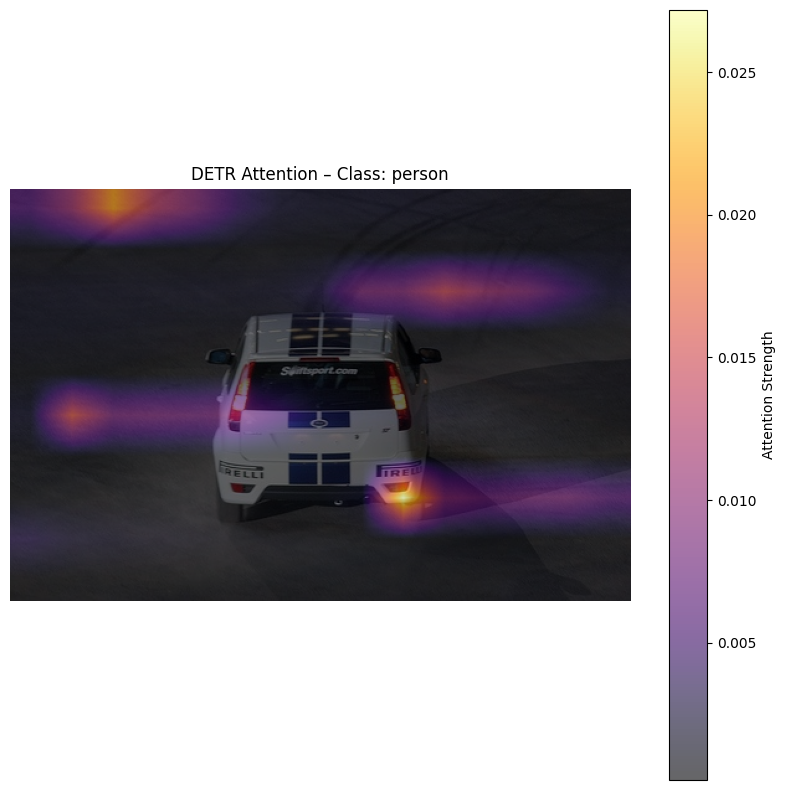

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Step 1: Load a sample image and get dimensions
sample_img, sample_target = train_dataset[0]
original_w, original_h = sample_img.size

# Step 2: Process image
inputs = processor(images=sample_img, return_tensors="pt").to(device)
pixel_values = inputs["pixel_values"]

# Step 3: Inference with attention
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values, output_attentions=True)

# Step 4: Get cross-attention from the last decoder layer
cross_attn = outputs.cross_attentions[-1][0]  # shape: [num_heads, num_queries, num_pixels]

# Step 5: Pick top query (most confident object prediction)
probs = outputs.logits.softmax(-1)[0, :, :-1]
scores, labels = probs.max(-1)
top_query_idx = scores.argmax().item()

# Step 6: Average over attention heads for top query
attn_map = cross_attn[:, top_query_idx, :].mean(0)  # [num_pixels]

# Step 7: Determine feature map size (typically 32x downsampled)
h_feat, w_feat = original_h // 32, original_w // 32
attn_map = attn_map[:h_feat * w_feat]  # make sure it's a perfect reshape
attn_map = attn_map.reshape(h_feat, w_feat).cpu().numpy()

# Step 8: Resize attention to original image dimensions
attn_map_tensor = torch.tensor(attn_map).unsqueeze(0).unsqueeze(0)
attn_resized = F.interpolate(attn_map_tensor, size=(original_h, original_w), mode="bilinear", align_corners=False)[0, 0].numpy()

# Step 9: Overlay attention on image
plt.figure(figsize=(10, 10))
plt.imshow(sample_img)
plt.imshow(attn_resized, cmap='inferno', alpha=0.6)
plt.title(f"DETR Attention – Class: {VOC_CLASSES[labels[top_query_idx]]}")
plt.axis('off')
plt.colorbar(label='Attention Strength')
plt.show()
